In [25]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:

!pip install pillow 
!pip install numpy 
!pip install keras 
!pip install matplotlib 
!pip install lxml 
!pip install keras_cv 
!pip install pycocotools


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [27]:
#if you are using tensorflow metal you cannot use tensorflow hub

import tensorflow as tf
import keras
import numpy as np
#import PIL.Image as Image
import pycocotools 

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib

import os 
from lxml import etree

In [28]:
class_ids = [
    "ThumbsDown",
    "ThumbsUp"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Function below is able to process the images and annotations and put them in an array

In [29]:


def read_annotation_file(xml_file):
    """
    Reads a Pascal VOC-style XML file and returns bounding boxes as a NumPy array.
    """
    tree = etree.parse(xml_file) #parses xml file
    root = tree.getroot() #gets the top indice of the xml file
    
    boxes = []
    names = []
    for obj in root.findall("object"): #gets the objects in the object subclass
        name = obj.find("name").text #gets what's the name of this object
        bndbox = obj.find("bndbox")
         #goes into the boundbox subclass
        xmin = int(bndbox.find("xmin").text) #grabs the differenct xmins
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
        names.append(name)

        class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(name)]
        for name in names
    ]
    return boxes, class_ids

def get_x_and_y(path_to_images, path_to_annotations):
    """outputs an array of images and an array of annotations given a path to both files"""
    images_array = []
    bboxes_array = []
    names_array = []
    for image in os.listdir(path_to_images): 
        annotation_file_name = os.path.splitext(image)[0] + '.xml' #gets the annotation file name 
        annotation_file_path = os.path.join(path_to_annotations,annotation_file_name) #gets the path 
        BBoxes, Label_Name = read_annotation_file(annotation_file_path) # reads the files
        Image_path = os.path.join(path_to_images,image)
        images_array.append(Image_path)
        bboxes_array.append(BBoxes)
        names_array.append(Label_Name)
    
    
    return images_array, bboxes_array, names_array



Next extract the training data

In [30]:
images, bboxes, classes = get_x_and_y("Workspace/GoodOrBad/Images/ProcessedImages/","Workspace/GoodOrBad/Annotations/")

bboxes = tf.ragged.constant(bboxes)
classes = tf.ragged.constant(classes)
images1 = tf.ragged.constant(images)

data = tf.data.Dataset.from_tensor_slices((images1, classes, bboxes))


num_val = int(len(images) * .1) #creates a number of images to partition
val_data = data.take(num_val)
train_data = data.skip(num_val)




Next we need to edit the data that way it can be passed into the yolo model

yolo expects datasets to be in this format:

bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}

In [31]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(16)#16 is the batch size times 4 that way it doesn't batch similar images

train_ds = train_ds.ragged_batch(4, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

#same for the valuation dataset
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(16)
val_ds = val_ds.ragged_batch(4, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)


2025-10-08 22:27:14.194761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{function_node sequential_2_1_jittered_resize_2_1_map_while_body_104666}}{{node sequential_2_1/jittered_resize_2_1/map/while/map/while}}]]


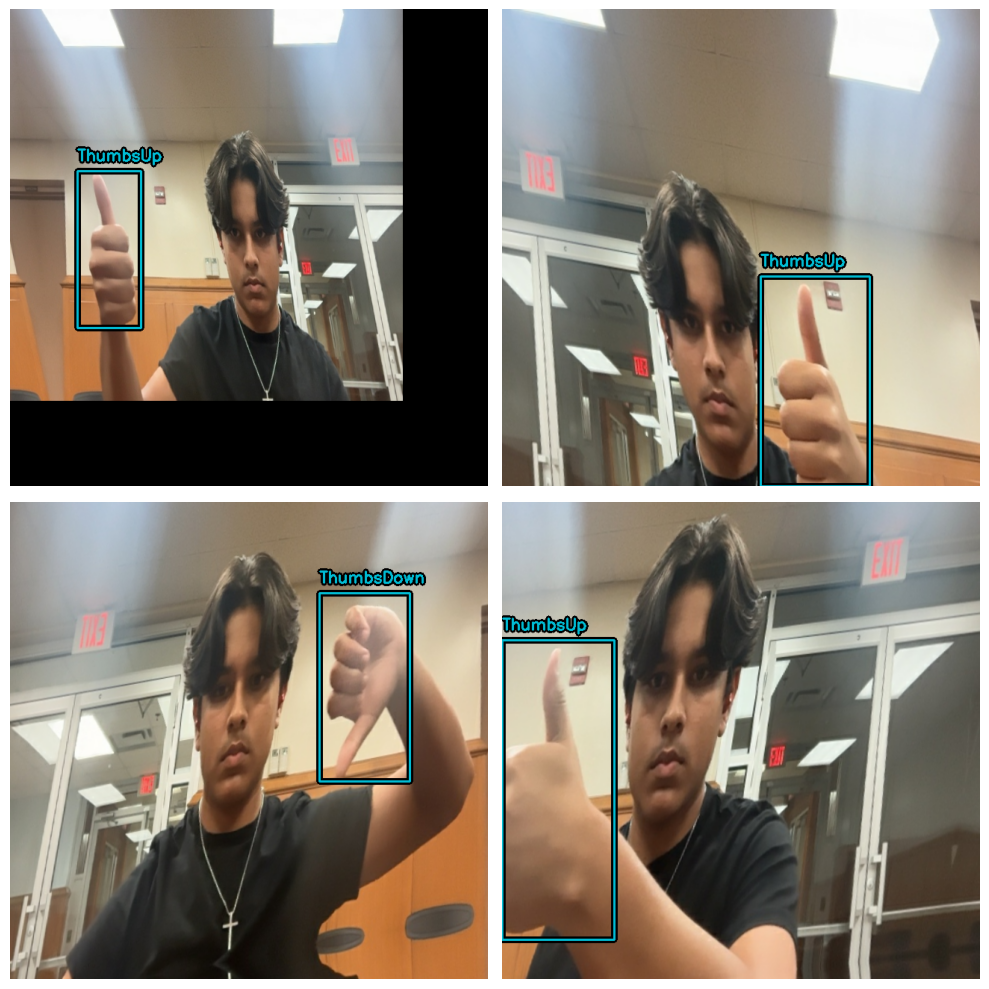

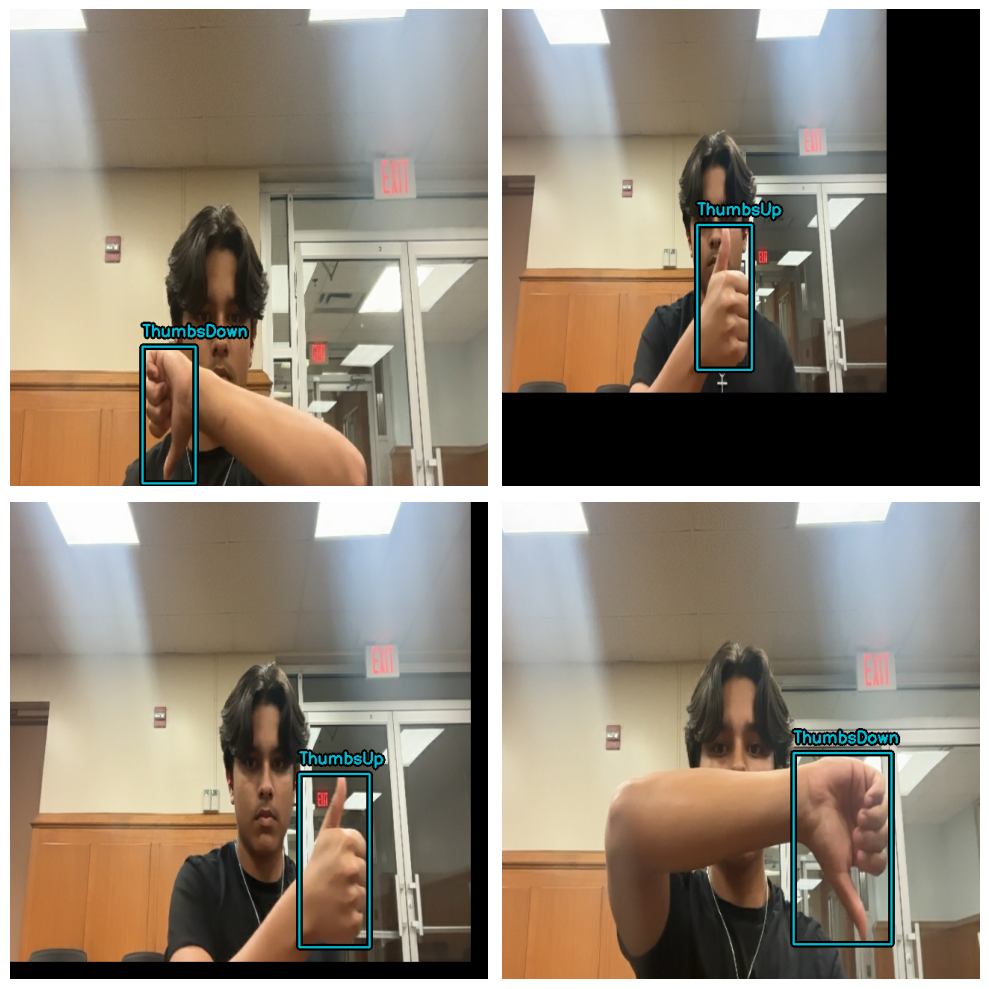

In [32]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [33]:
#make the dictionary in the datasets tuples

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]




train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
#visualize_dataset(train_ds)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE) #this line makes it so that it loads the next batch as the current is processing


val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
#visualize_dataset(val_ds)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


Next we define the model

In [34]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco"  # We will use yolov8 extra small backbone with coco weights but you have other options
)
#below is how you define the model
yolo = keras_cv.models.YOLOV8Detector(
    num_classes= 2,
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

#defining the optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm=10.0,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)


TypeError: EvaluateCOCOMetricsCallback.__init__() missing 1 required positional argument: 'save_path'

Next we create our callback. Imma be honest idk how this next few lines of code works

In [35]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [43]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - box_loss: 2.1616 - class_loss: 19.4737 - loss: 21.6352

2025-10-08 22:34:55.934451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - box_loss: 2.1103 - class_loss: 15.5570 - loss: 17.6673 - val_box_loss: 2.1713 - val_class_loss: 14.0652 - val_loss: 16.2365 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - box_loss: 2.0876 - class_loss: 6.1803 - loss: 8.2679

2025-10-08 22:36:10.204814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - box_loss: 2.0765 - class_loss: 4.9649 - loss: 7.0414 - val_box_loss: 3.2920 - val_class_loss: 207.2668 - val_loss: 210.5588 - MaP: 2.1216e-05 - MaP@[IoU=50]: 1.0608e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.1216e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0143 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0143
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - box_loss: 2.0323 - class_loss: 2.6684 - loss: 4.7007 - val_box_loss: 2.2359 - val_class_loss: 4.0279 - val_loss: 6.2637 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0

2025-10-08 22:37:25.077216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - box_loss: 2.0191 - class_loss: 2.2073 - loss: 4.2264

2025-10-08 22:38:37.065385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - box_loss: 2.0061 - class_loss: 2.1058 - loss: 4.1118 - val_box_loss: 2.2414 - val_class_loss: 3.5439 - val_loss: 5.7853 - MaP: 0.0023 - MaP@[IoU=50]: 0.0070 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0023 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0437 - Recall@[max_detections=100]: 0.0437 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0437
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.9705 - class_loss: 1.7472 - loss: 3.7177

2025-10-08 22:39:29.746138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - box_loss: 2.0110 - class_loss: 1.7383 - loss: 3.7493 - val_box_loss: 2.0850 - val_class_loss: 7.9747 - val_loss: 10.0597 - MaP: 0.0584 - MaP@[IoU=50]: 0.1906 - MaP@[IoU=75]: 0.0010 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0628 - Recall@[max_detections=1]: 0.0688 - Recall@[max_detections=10]: 0.2313 - Recall@[max_detections=100]: 0.2313 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.2455
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.9390 - class_loss: 1.6059 - loss: 3.5449

2025-10-08 22:40:21.415639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - box_loss: 1.9534 - class_loss: 1.5147 - loss: 3.4681 - val_box_loss: 1.9916 - val_class_loss: 1.4768 - val_loss: 3.4684 - MaP: 0.2475 - MaP@[IoU=50]: 0.5792 - MaP@[IoU=75]: 0.1386 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.2475 - Recall@[max_detections=1]: 0.2400 - Recall@[max_detections=10]: 0.3100 - Recall@[max_detections=100]: 0.3100 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3100
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - box_loss: 2.0228 - class_loss: 1.3958 - loss: 3.4186 - val_box_loss: 2.2724 - val_class_loss: 1.2795 - val_loss: 3.5519 - MaP: 0.1552 - MaP@[IoU=50]: 0.3960 - MaP@[IoU=75]: 0.1081 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.1552 - Recall@[max_detections=1]: 0.1429 - Recall@[max_detections=10]: 0.2726 - Recall@[max_detections=100]: 0.2726 - Recall@[area=small]: 0.0000e+00 - Recall@[ar

2025-10-08 22:41:17.864961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - box_loss: 1.9541 - class_loss: 1.1866 - loss: 3.1408

2025-10-08 22:42:06.603886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - box_loss: 1.9415 - class_loss: 1.1726 - loss: 3.1141 - val_box_loss: 1.9003 - val_class_loss: 1.1653 - val_loss: 3.0656 - MaP: 0.2965 - MaP@[IoU=50]: 0.6460 - MaP@[IoU=75]: 0.1747 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.2965 - Recall@[max_detections=1]: 0.3911 - Recall@[max_detections=10]: 0.4643 - Recall@[max_detections=100]: 0.4643 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.4643
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - box_loss: 1.9651 - class_loss: 1.0687 - loss: 3.0338 - val_box_loss: 2.4010 - val_class_loss: 1.2033 - val_loss: 3.6044 - MaP: 0.1508 - MaP@[IoU=50]: 0.3272 - MaP@[IoU=75]: 0.1262 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.1508 - Recall@[max_detections=1]: 0.2750 - Recall@[max_detections=10]: 0.2750 - Recall@[max_detections=100]: 0.2750 - Recall@[area=small]: 0.0000e+00 - Recall@[ar

2025-10-08 22:43:00.747758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - box_loss: 1.9296 - class_loss: 1.0402 - loss: 2.9698

2025-10-08 22:43:49.285357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - box_loss: 1.8978 - class_loss: 1.0320 - loss: 2.9298 - val_box_loss: 1.9772 - val_class_loss: 2.0441 - val_loss: 4.0213 - MaP: 0.5178 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.2079 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5178 - Recall@[max_detections=1]: 0.5200 - Recall@[max_detections=10]: 0.5200 - Recall@[max_detections=100]: 0.5200 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5200
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - box_loss: 1.8889 - class_loss: 0.9281 - loss: 2.8170 - val_box_loss: 2.0739 - val_class_loss: 1.1521 - val_loss: 3.2259 - MaP: 0.3395 - MaP@[IoU=50]: 0.6827 - MaP@[IoU=75]: 0.3339 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.3395 - Recall@[max_detections=1]: 0.4450 - Recall@[max_detections=10]: 0.4450 - Recall@[max_detections=100]: 0.4450 - Recall@[area=small]: 0.0000e+00 - Recall@[a

2025-10-08 22:44:38.920815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - box_loss: 1.8979 - class_loss: 0.8930 - loss: 2.7909 - val_box_loss: 2.0924 - val_class_loss: 1.1894 - val_loss: 3.2818 - MaP: 0.3682 - MaP@[IoU=50]: 0.8185 - MaP@[IoU=75]: 0.0605 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.3682 - Recall@[max_detections=1]: 0.3850 - Recall@[max_detections=10]: 0.4667 - Recall@[max_detections=100]: 0.4667 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.4667
Epoch 13/20


2025-10-08 22:45:31.034681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - box_loss: 1.8710 - class_loss: 0.8247 - loss: 2.6957 - val_box_loss: 1.8226 - val_class_loss: 1.0453 - val_loss: 2.8679 - MaP: 0.2401 - MaP@[IoU=50]: 0.5763 - MaP@[IoU=75]: 0.0878 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.2401 - Recall@[max_detections=1]: 0.2583 - Recall@[max_detections=10]: 0.3750 - Recall@[max_detections=100]: 0.3750 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3750
Epoch 14/20


2025-10-08 22:46:30.548198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - box_loss: 1.8529 - class_loss: 0.7838 - loss: 2.6367 - val_box_loss: 1.9665 - val_class_loss: 0.9883 - val_loss: 2.9549 - MaP: 0.4080 - MaP@[IoU=50]: 0.7493 - MaP@[IoU=75]: 0.4012 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.4080 - Recall@[max_detections=1]: 0.4412 - Recall@[max_detections=10]: 0.5100 - Recall@[max_detections=100]: 0.5100 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5100
Epoch 15/20


2025-10-08 22:47:26.256826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - box_loss: 1.8675 - class_loss: 0.7744 - loss: 2.6419 - val_box_loss: 2.2183 - val_class_loss: 1.3895 - val_loss: 3.6078 - MaP: 0.3340 - MaP@[IoU=50]: 0.9226 - MaP@[IoU=75]: 0.0842 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.3340 - Recall@[max_detections=1]: 0.3917 - Recall@[max_detections=10]: 0.3917 - Recall@[max_detections=100]: 0.3917 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.3917
Epoch 16/20


2025-10-08 22:48:19.835379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - box_loss: 1.7029 - class_loss: 0.7133 - loss: 2.4162 - val_box_loss: 2.1539 - val_class_loss: 0.9900 - val_loss: 3.1438 - MaP: 0.3365 - MaP@[IoU=50]: 0.9356 - MaP@[IoU=75]: 0.1264 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.3365 - Recall@[max_detections=1]: 0.3875 - Recall@[max_detections=10]: 0.4125 - Recall@[max_detections=100]: 0.4125 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.4125
Epoch 17/20


2025-10-08 22:49:20.885967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 932ms/step - box_loss: 1.7141 - class_loss: 0.7051 - loss: 2.4192 - val_box_loss: 2.0506 - val_class_loss: 1.5110 - val_loss: 3.5616 - MaP: 0.4804 - MaP@[IoU=50]: 0.7710 - MaP@[IoU=75]: 0.5520 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.4804 - Recall@[max_detections=1]: 0.6000 - Recall@[max_detections=10]: 0.6000 - Recall@[max_detections=100]: 0.6000 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.6000
Epoch 18/20


2025-10-08 22:50:03.430607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.7152 - class_loss: 0.7530 - loss: 2.4682

2025-10-08 22:51:05.903859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - box_loss: 1.6685 - class_loss: 0.7361 - loss: 2.4046 - val_box_loss: 1.7609 - val_class_loss: 0.7027 - val_loss: 2.4636 - MaP: 0.5181 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.5737 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5181 - Recall@[max_detections=1]: 0.5350 - Recall@[max_detections=10]: 0.5550 - Recall@[max_detections=100]: 0.5550 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5550
Epoch 19/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - box_loss: 1.6350 - class_loss: 0.6553 - loss: 2.2902 - val_box_loss: 1.7628 - val_class_loss: 0.6996 - val_loss: 2.4625 - MaP: 0.4268 - MaP@[IoU=50]: 0.7878 - MaP@[IoU=75]: 0.3584 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.4268 - Recall@[max_detections=1]: 0.4604 - Recall@[max_detections=10]: 0.5708 - Recall@[max_detections=100]: 0.5708 - Recall@[area=small]: 0.0000e+00 - Recall@[a

2025-10-08 22:52:13.003534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - box_loss: 1.6073 - class_loss: 0.6301 - loss: 2.2374

2025-10-08 22:53:05.839207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - box_loss: 1.5948 - class_loss: 0.6301 - loss: 2.2249 - val_box_loss: 1.8398 - val_class_loss: 0.6176 - val_loss: 2.4574 - MaP: 0.5197 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.3465 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.2000 - MaP@[area=large]: 0.5480 - Recall@[max_detections=1]: 0.5571 - Recall@[max_detections=10]: 0.5571 - Recall@[max_detections=100]: 0.5571 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.2000 - Recall@[area=large]: 0.5869


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


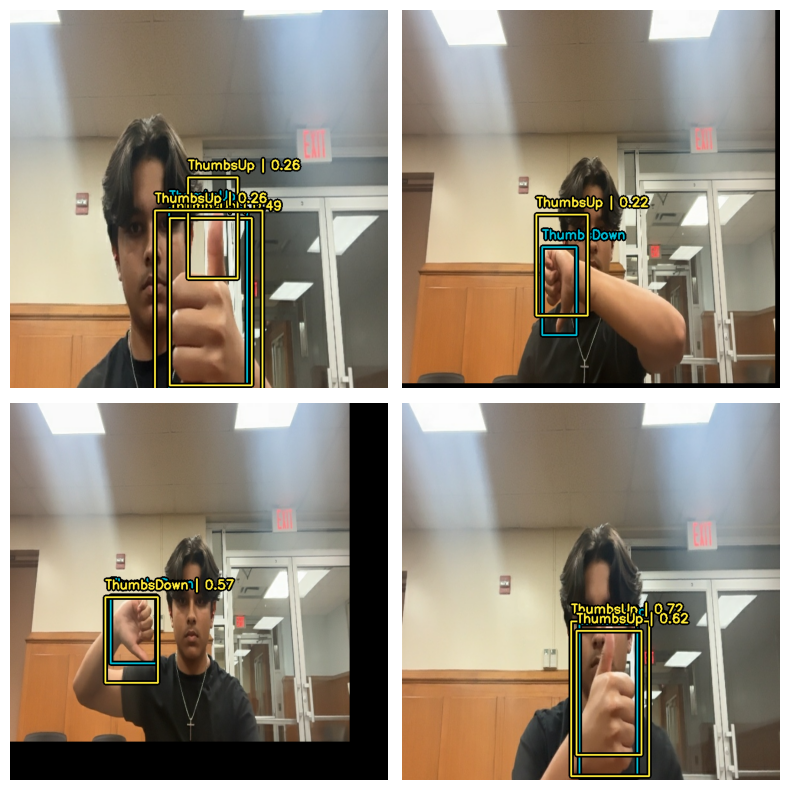

In [44]:
import cv2
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)

    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

NameError: name 'loaded_model' is not defined